## Pricipal Coordinate Analysis (PCA)

At times, when you're working with complex data, you have so many variables that you're not sure where to start...It's in these cases, when you have many variables to consider that I often turn to PCA.

In these situations of variable-overload, I often struggle to understand the relationships between each variable.  Am I overfitting a model -- its hard to tell with so many variables?  I'm also often concerned that I may be violating assumptions of a model, especially that featurse are independent. 

PCA helps to reduce the dimension of your feature space. By reducing the dimension of your feature space, you have fewer relationships between variables to consider and you are less likely to overfit your model. (Note: This doesn’t immediately mean that overfitting, etc. are no longer concerns!)

Reducing the dimension of the feature space is called more officially “dimensionality reduction.” There are many ways to achieve dimensionality reduction, but most of these techniques fall into one of two classes:

* Feature Elimination
* Feature Extraction

Feature elimination is what it sounds like: we reduce the feature space by eliminating features.  Instead of considering all 100 features, we'll only use 10. Advantages of feature elimination methods include simplicity and maintaining interpretability of your variables. As a disadvantage, though, you gain no information from those variables you’ve dropped (and they may be important!).

Feature extraction, however, doesn’t run into this problem. Say we have ten independent variables. In feature extraction, we create ten “new” independent variables, where each “new” independent variable is a combination of each of the ten “old” independent variables. However, we create these new independent variables in a specific way and order these new variables by how well they predict our dependent variable.  In the Statquest video, these were the fitted eigenvectors he discussed.

Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables! As an added benefit, each of the “new” variables after PCA are all independent of one another. This is a benefit because the assumptions of a linear model require our independent variables to be independent of one another. If we decide to fit a linear regression model with these “new” variables, this assumption will necessarily be satisfied.

#### When should PCA be used?

* Do you want to reduce the number of variables, but aren’t able to identify variables to completely remove from consideration?
* Do you want to ensure your variables are independent of one another?
* Are you comfortable making your independent variables less interpretable?

If you answered “yes” to all three questions, then PCA is a good method to use. If you answered “no” to question 3, you should not use PCA.

Content based on https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

### Dataset for PCA

We are going to be working with the digital images of tumor cells from our previous SVM tutorial.  You'll remember that we have tumor images to predict whether the tumors are malignant or benign.

For each image, ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

Additionally, the mean, standard error and “worst” or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features.  

Let's start with bringing int he dataset and taking a quick look at it....

In [1]:
# Sometimes plots dont show up and this makes it better

%matplotlib inline 

In [2]:
import pandas as pd
dataset = pd.read_csv('cancer.csv')
dataset.head()

,ID,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,conc_mean,conc_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,conc_worst,conc_points_worst,symmetry_worst,fractral_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
print("Shape of our tumor cell dataset:", dataset.shape)

Shape of our tumor cell dataset: (569, 32)


In [4]:
print(dataset.columns)

Index(['ID', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'conc_mean',
       'conc_points_mean', 'symmetry_mean', 'fractral_mean', 'radius_se',
       'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'conc_se', 'conc_points_se', 'symmetry_se',
       'fractral_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'smoothness_worst', 'compactness_worst', 'conc_worst',
       'conc_points_worst', 'symmetry_worst', 'fractral_worst'],
      dtype='object')


Let's select the mean, errors, and worst columns as separate dataframes.  We've done this several different ways, usign iloc, using specific column names.  This method is probably one I use a lot.

In [5]:
feature_mean = list(dataset.columns[2:12])
feature_error = list(dataset.columns[12:22])
feature_worst = list(dataset.columns[22:32])

In [6]:
print(feature_mean, feature_error, feature_worst)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'conc_mean', 'conc_points_mean', 'symmetry_mean', 'fractral_mean'] ['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'conc_se', 'conc_points_se', 'symmetry_se', 'fractral_se'] ['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'conc_worst', 'conc_points_worst', 'symmetry_worst', 'fractral_worst']


Make a correlation plot of the average values.

In [7]:
dataset_mean = dataset[list(dataset.columns[2:12])]
corr = dataset_mean.corr(method='pearson')

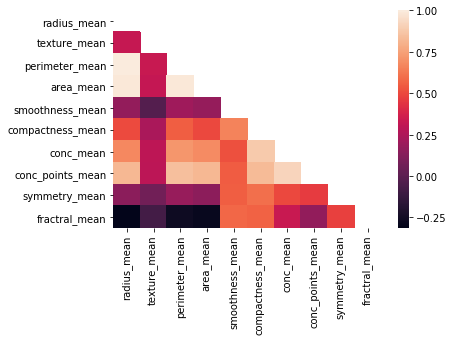

In [8]:
import seaborn as sns 
import numpy as np
import matplotlib 

# This removes the top half redundancy on heatmp
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plots the heatmap

sns.heatmap(corr, mask=mask)

On your Own:  Make at least one other plot to explore the correlations within this dataset. 
Make a correlation plot of the worst values. 

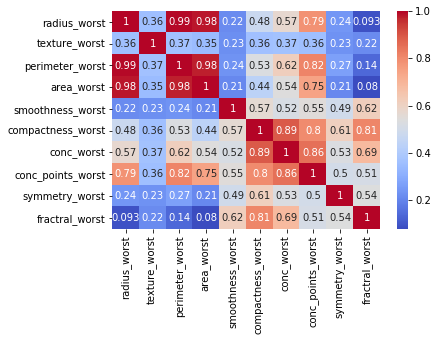

In [9]:
dataset_worst = dataset[list(dataset.columns[22:32])]
corr2 = dataset_worst.corr(method='pearson')

sns.heatmap(corr2, annot = True, cmap = 'coolwarm')

In [10]:
# Let's define our X and Y datasets for machine learning in scikit
X_data = dataset.iloc[:, 2:32]
Y_data = dataset.iloc[:,1]

###  Scaling data is important for PCAs

Feature scaling through standardization (or Z-score normalization) can be an important preprocessing step for many machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.

While many algorithms (such as SVM, K-nearest neighbors, and logistic regression) require features to be normalized.  Principle Component Analysis (PCA) is a prime example of when normalization is also important. 

In PCA we are interested in the components that maximize the variance. If one component (e.g. human height) varies less than another (e.g. weight) because of their respective scales (meters vs. kilos), PCA might determine that the direction of maximal variance more closely corresponds with the ‘weight’ axis, if those features are not scaled. As a change in height of one meter can be considered much more important than the change in weight of one kilogram, this is clearly incorrect.

[Source Documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)

In [11]:
from sklearn.preprocessing import StandardScaler

# Documentation - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaled_data = StandardScaler()
scaled_X = scaled_data.fit_transform(X_data)

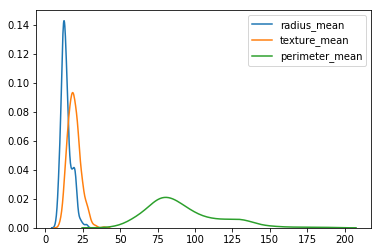

In [12]:
sns.kdeplot(X_data.iloc[:,0])
sns.kdeplot(X_data.iloc[:,1])
sns.kdeplot(X_data.iloc[:,2])

(0, 0.6)

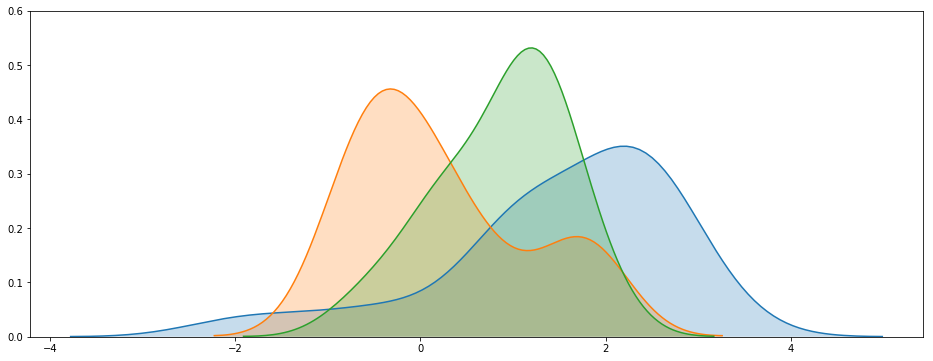

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6)) 
#Do you know what this does? Create a figure and set figure size

sns.kdeplot(scaled_X[0], shade = True)
sns.kdeplot(scaled_X[1], shade = True)
sns.kdeplot(scaled_X[2], shade = True)
plt.ylim(0, 0.6)

In the code above, what do the arguments 'stratify' and 'random_state' specify and when might you use them? 

The argument 'stratify' is to specify whether the data is array-like or none(default), data will be splited in a stratified fashion using this as the labels array if not none. For 'random_state' argument, if it's set to be 1, the code will give same result every time; if it's set to be 2, it will happen as well but probably with different values than before; if it's set to be none(default), the code will choose random seed and get different result every time. 

In [14]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=4)
# fit PCA on training set
pca1.fit(scaled_X)

train_pca1 = pca1.transform(scaled_X)

In [15]:
pc_df = pd.DataFrame(data = train_pca1, columns = ['PC1', 'PC2','PC3','PC4'])
pc_df['Cluster'] = Y_data
pc_df.head

<bound method NDFrame.head of            PC1        PC2       PC3       PC4 Cluster
0     9.192837   1.948583 -1.123166  3.633731       M
1     2.387802  -3.768172 -0.529293  1.118264       M
2     5.733896  -1.075174 -0.551748  0.912083       M
3     7.122953  10.275589 -3.232790  0.152547       M
4     3.935302  -1.948072  1.389767  2.940639       M
5     2.380247   3.949929 -2.934877  0.941037       M
6     2.238883  -2.690031 -1.639913  0.149340       M
7     2.143299   2.340244 -0.871947 -0.127043       M
8     3.174924   3.391813 -3.119986 -0.601297       M
9     6.351747   7.727174 -4.341916 -3.375202       M
10   -0.810414  -2.659275 -0.488830 -1.672567       M
11    2.651100   0.066568 -1.526455  0.051262       M
12    8.185034   2.700976  5.730231 -1.112257       M
13    0.342126  -0.968279  1.717172 -0.595003       M
14    4.342379   4.861083 -2.816116 -1.454557       M
15    4.075656   2.977061 -3.125274 -2.458071       M
16    0.230055  -1.564758 -0.802519 -0.650583       

Let's take a look at our trained dataset and how much was explained by each principle coordinate.

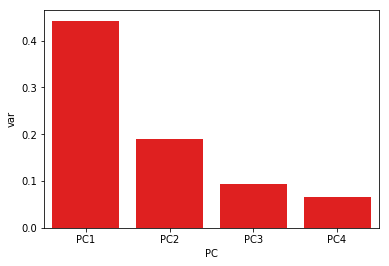

In [16]:
df = pd.DataFrame({'var':pca1.explained_variance_ratio_, 'PC':['PC1','PC2','PC3','PC4']})
sns.barplot(x='PC',y="var", data=df, color="red");

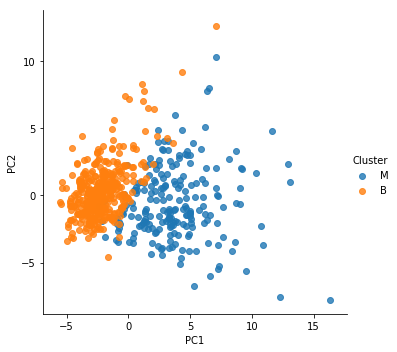

In [17]:
p = sns.lmplot( x="PC1", y="PC2", data=pc_df, fit_reg=False, hue='Cluster', legend=True) 
# specify the point size
p

Some other tutorials (that are potentially useful):

1.  PCA followed by regression:  https://nirpyresearch.com/principal-component-regression-python/
2.  Manually doing a PCA, more math theory: https://sebastianraschka.com/Articles/2014_pca_step_by_step.html
3.  Generic PCA with a different dataset:  https://medium.com/district-data-labs/principal-component-analysis-with-python-4962cd026465

## Another Dataset: Wine
The dataset contain the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

Details can be [**found here**](http://archive.ics.uci.edu/ml/datasets/Wine).

In [18]:
df = pd.read_csv('wine.data.csv', header=None)
df.columns = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df.head(10)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [19]:
print("Shape of the wine dataset:", df.shape)

Shape of the wine dataset: (178, 14)


In [20]:
dfc = df[list(df.columns[1:14])]
corrw = dfc.corr(method='pearson')

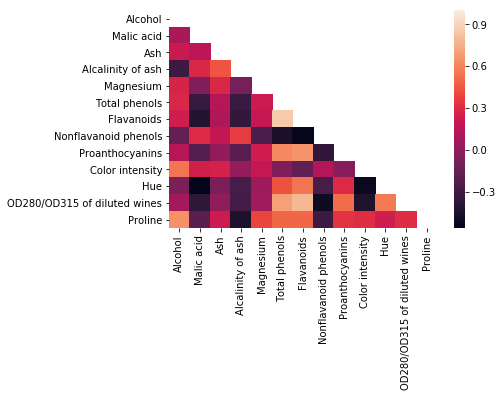

In [21]:
# removes the top half redundancy on heatmp
maskw = np.zeros_like(corrw)
maskw[np.triu_indices_from(maskw)] = True

# plot the heatmap

sns.heatmap(corrw, mask=maskw)

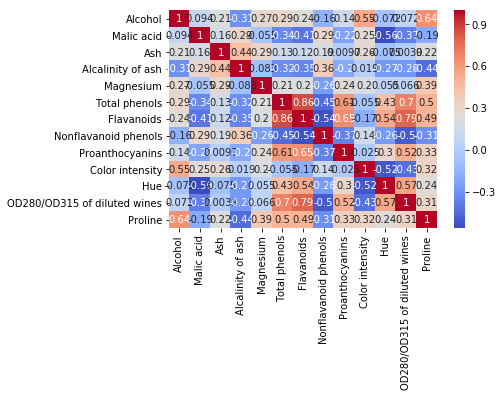

In [22]:
sns.heatmap(corrw, annot = True, cmap = 'coolwarm')

/Users/joylee/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/joylee/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


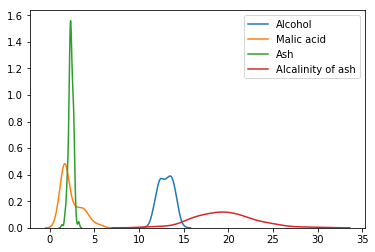

In [23]:
# define our X and Y datasets for machine learning in scikit
X_dataw = df.iloc[:, 1:14]
Y_dataw = df.iloc[:,0]

scaled_Xw = scaled_data.fit_transform(X_dataw)

sns.kdeplot(X_dataw.iloc[:,0])
sns.kdeplot(X_dataw.iloc[:,1])
sns.kdeplot(X_dataw.iloc[:,2])
sns.kdeplot(X_dataw.iloc[:,3])

(0, 0.6)

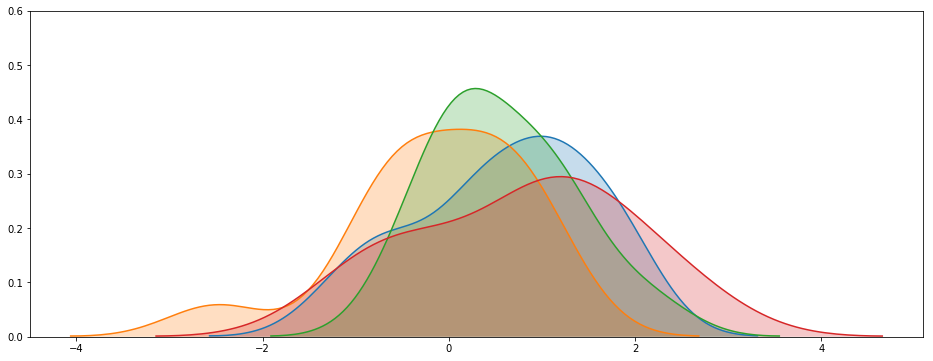

In [24]:
# Create a figure and set size
plt.figure(figsize=(16, 6))

sns.kdeplot(scaled_Xw[0], shade = True)
sns.kdeplot(scaled_Xw[1], shade = True)
sns.kdeplot(scaled_Xw[2], shade = True)
sns.kdeplot(scaled_Xw[3], shade = True)
plt.ylim(0, 0.6)

In [25]:
pca2 = PCA(n_components=4)
# fit PCA on training set
pca2.fit(scaled_Xw)

train_pca2 = pca2.transform(scaled_Xw)

pc_dfw = pd.DataFrame(data = train_pca2, columns = ['PC1', 'PC2','PC3','PC4'])
pc_dfw['Cluster'] = Y_dataw
pc_dfw.head

<bound method NDFrame.head of           PC1       PC2       PC3       PC4  Cluster
0    3.316751 -1.443463 -0.165739 -0.215631        1
1    2.209465  0.333393 -2.026457 -0.291358        1
2    2.516740 -1.031151  0.982819  0.724902        1
3    3.757066 -2.756372 -0.176192  0.567983        1
4    1.008908 -0.869831  2.026688 -0.409766        1
5    3.050254 -2.122401 -0.629396 -0.515637        1
6    2.449090 -1.174850 -0.977095 -0.065831        1
7    2.059437 -1.608963  0.146282 -1.192608        1
8    2.510874 -0.918071 -1.770969  0.056270        1
9    2.753628 -0.789438 -0.984247  0.349382        1
10   3.479737 -1.302333 -0.422735  0.026842        1
11   1.754753 -0.611977 -1.190878 -0.890164        1
12   2.113462 -0.675706 -0.865086 -0.356438        1
13   3.458157 -1.130630 -1.204276  0.162458        1
14   4.312784 -2.095976 -1.263913  0.305773        1
15   2.305188 -1.662552  0.217903 -1.440590        1
16   2.171955 -2.327305  0.831730 -0.912601        1
17   1.898971 -1

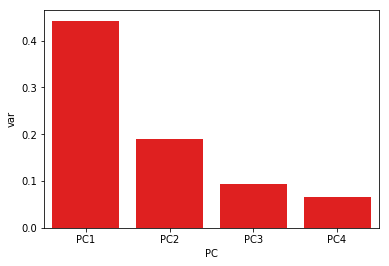

In [26]:
dfw = pd.DataFrame({'var':pca1.explained_variance_ratio_, 'PC':['PC1','PC2','PC3','PC4']})
sns.barplot(x='PC',y="var", data=dfw, color="red");

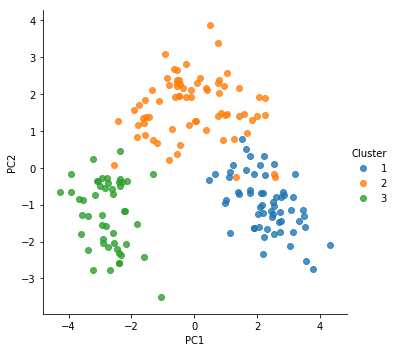

In [27]:
p1 = sns.lmplot( x="PC1", y="PC2", data=pc_dfw, fit_reg=False, hue='Cluster', legend=True) 
p1

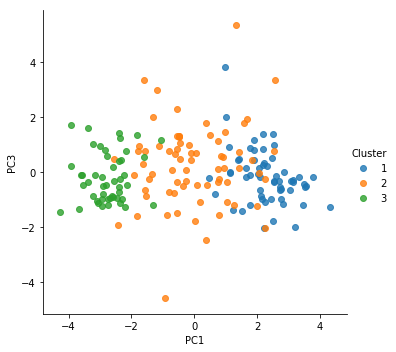

In [28]:
p2 = sns.lmplot( x="PC1", y="PC3", data=pc_dfw, fit_reg=False, hue='Cluster', legend=True) 
p2

The PCA model has been trained on the wine dataset with four principle coordinates. Based on the scatter plots of principle coordinates, PC1 and PC2 gives excellent result in terms of seperating three wine classes. To get more optimal classification, we can use three features for the model since this is a relatively small dataset. Original code and data are posted on github. (https://github.com/joyleeisu/ABE516X-PCA.git)